In [1]:
shape_cat="mcal"
vol="vlim"
z_range="all_z"


lambda_range=0
with_r=True

In [2]:
# matplotlib.rcParams.update({'font.size': 11}) # before plotting coode
# plt.figure(figsize=(6.2,5))
# ...
# plt.tight_layout()
# plt.subplots_adjust(hspace=0,wspace=0) # if doing multiple panels/subplots
# plt.savefig('namee.pdf', bbox_inches='tight')

In [3]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import fitsio as fio
import numpy as np
import ast

import astropy.cosmology
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from IPython.display import display, Math
from tqdm.notebook import tqdm
tqdm.pandas()

/global/homes/z/zchusre/.conda/envs/desdesi/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
#This header file contains all the common packages
%matplotlib inline
%run -i /global/project/projectdirs/des/zhou/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /global/project/projectdirs/des/zhou/sa/lib/src/func.py  
%run -i /global/project/projectdirs/des/zhou/sa/lib/src/corr_func.py

sources= pd.read_pickle("/global/project/projectdirs/des/zhou/sa/data/BPZ.pkl") #load BPZ catalog
LRGs=pd.read_pickle("/global/project/projectdirs/des/zhou/sa/data/shape_BPZ.pkl")
LRGs_index=LRGs.index
LRGs=None

In [5]:
sources

Band             All                                                         \
Data              e1        e2 flags_select          RA       DEC    mean_z   
ID                                                                            
3007825738 -0.067457 -0.108823            0  318.189343  0.373614  0.592499   
3007825739 -0.241395 -0.168924            0  317.966101  0.373698  1.144830   
3007825742 -0.003933  0.491628            0  317.586931  0.373745  0.493385   
3007825768 -0.005586 -0.118534            0  318.013978  0.374081  1.024960   
3007825777 -0.019404  0.043441            0  317.534582  0.374336  0.417675   
...              ...       ...          ...         ...       ...       ...   
3172249251 -0.116175 -0.202291            0  150.342516  2.505051  1.049819   
3172249272  0.016469 -0.152172            0  149.846985  2.502264  0.694110   
3172249301 -0.129176 -0.203288            0  149.940544  2.498567  0.619950   
3172249302 -0.054150 -0.058570            0  150.311284  2.511910  0.559759   
3172249303  0.222809 -0.212190            0  149.872793  2.512517  0.537623   

Band                     
Data               angR  
ID                       
3007825738   959.643276  
3007825739  1188.569227  
3007825742   875.095067  
3007825768  1162.923418  
3007825777   796.230941  
...                 ...  
3172249251  1169.027836  
3172249272  1028.266779  
3172249301   979.825672  
3172249302   933.825849  
3172249303   915.227695  

[34714036 rows x 7 columns]

In [6]:
print("The number of total sources is {}".format(len(sources)))
print("The number of LRGs is {}".format(len(LRGs_index)))

The number of total sources is 34714036
The number of LRGs is 105029


In [7]:
NBINS=10

z_bins=np.arange(0.2,0.67,0.15)
lambda_bins=np.append(np.arange(20,66,15),1000)

print(z_bins)
print(lambda_bins)

[0.2  0.35 0.5  0.65]
[  20   35   50   65 1000]


In [8]:
woRedMask=~np.isin(sources.index,LRGs_index)

In [9]:
print("The number of sources excluding LGRs is {}".format(np.sum(woRedMask)))
print("The number of LRG sources being cut is {}".format(np.sum(~woRedMask)))

The number of sources excluding LGRs is 34609603
The number of LRG sources being cut is 104433


In [10]:
lambda_bins[-1]

1000

In [11]:
def get_ng_source(_clusters,_sources,_shapes,z_lower=z_bins[0],z_upper=z_bins[-1],lambda_lower=lambda_bins[0],lambda_upper=lambda_bins[-1],foreback=False,woRed=False,multi=True):
#     print(len(_clusters))

#     print(_clusters)
    
    if multi==False:
        assert len(_clusters)==1
        clusters_masked=_clusters
    else:
        assert len(_clusters)!=1
        clusters_z_mask=(_clusters[('All','All','Z_LAMBDA')]>=z_lower)&(_clusters[('All','All','Z_LAMBDA')]<=z_upper)
        clusters_lambda_mask=(_clusters[('All','All','LAMBDA_CHISQ')]>=lambda_lower)&(_clusters[('All','All','LAMBDA_CHISQ')]<=lambda_upper)
        combined_mask=clusters_z_mask&clusters_lambda_mask
        clusters_masked=_clusters[combined_mask]
        
        
    
    
    if woRed==True:
        _sources=_sources[woRedMask]
        
        
        
    center_id=clusters_masked[('Alt','Alt1','ID_CENT')]
    centers=_shapes.loc[center_id]
    
#     print(center_id)
#     print(centers)
    
    
    
    
    assert ~np.any(np.isnan(centers[('All','RA')]))
    
#     print("The number of clusters is {}".format(len(clusters_masked)))
#     print("The number of sources is {}".format(len(sources)))
    
    
    UPPER_BOUND=10
    distance=('All','angR')


#     if mode1 == "s":
#         def get_cluster_cen(cluster):
#             return (get_unique_center_for_cluster(cluster))
#         def get_cluster_sats(cluster):
#             cen_mat_id=cluster.name
#             cen_id=cluster[('Alt','Alt1','ID_CENT')]
            

            
#             if source==True:
#                 sats=members
                
#             else: 
#                 sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
                         
#             sats=sats[sats.index!=cen_id]
#             return (sats)
#     elif mode1=='r':
#         def get_cluster_sats(cluster):
#             return(shapes)
#         def get_cluster_cen(cluster):
#             return (random)

#     else:
#         raise


    cen=centers
    sats=sources
    
#     if foreback=="back":
#         sats=sats[(sats[('All','mean_z')]-z_upper)>=0.1]
#         print("The number of background sources is {}".format(len(sats)))
#     elif foreback=="fore":
#         sats=sats[(z_lower-sats[('All','mean_z')])>=0.1]
#         print("Calculating foreground sources")
#         print(sats[('All','mean_z')].mean())
#         print("The number of foreground sources is {}".format(len(sats)))

    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]
    

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()
        




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')
    
    MINSEP=0.1
    BINSLOP=0.1
        

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=MINSEP, max_sep=UPPER_BOUND, bin_slop=BINSLOP,
                               metric="Rperp")
    

    ng.process(cen_cat,sats_cat)

    return(ng)

In [12]:
## lambda x z = 4x3
import gc

# def get_ng_values(clusters,members,z_bins_low,z_bins_high,lambda_bins_low,lambda_bins_high,foreback):
#     ng=get_ng_source(clusters,members,z_bins_low,z_bins_high,lambda_bins_low,lambda_bins_high,foreback)
#     ng_values=np.copy(np.array([ng.meanlogr,ng.xi,ng.varxi]))
    
#     del ng
    
#     return(ng_values)
    
ng_matrix=[[None for i in range(4)] for j in range(3)]

for i in trange(3):
    for j in trange(4):
        ng=get_ng_source(clusters,sources,shapes,z_bins[i],z_bins[i+1],lambda_bins[j],lambda_bins[j+1],foreback="")
        ng_values=np.copy(np.array([ng.meanlogr,ng.xi,ng.varxi]))
        ng_matrix[i][j]=ng_values
        del ng
        gc.collect()

The number of clusters is 371
The number of sources is 34714036
The number of clusters is 88
The number of sources is 34714036
The number of clusters is 25
The number of sources is 34714036
The number of clusters is 20
The number of sources is 34714036



The number of clusters is 1238
The number of sources is 34714036
The number of clusters is 260
The number of sources is 34714036
The number of clusters is 64
The number of sources is 34714036
The number of clusters is 55
The number of sources is 34714036



The number of clusters is 1539
The number of sources is 34714036
The number of clusters is 303
The number of sources is 34714036
The number of clusters is 89
The number of sources is 34714036
The number of clusters is 40
The number of sources is 34714036




In [13]:
np.save("/global/project/projectdirs/des/zhou/sa/data/gammaT/ng_matrix.npy",ng_matrix)
ng_matrix=None

In [13]:
## lambda x z = 4x3
ng_wr_matrix=[[None for i in range(4)] for j in range(3)]

import gc


for i in trange(3): #z bins
    for j in trange(4): # lambda bins
        ng=get_ng_source(clusters,sources,shapes,z_bins[i],z_bins[i+1],lambda_bins[j],lambda_bins[j+1],foreback="",woRed=True)
        ng_values=np.copy(np.array([ng.meanlogr,ng.xi,ng.varxi]))
        ng_wr_matrix[i][j]=ng_values
        del ng
        gc.collect()

The number of clusters is 371
The number of sources is 34714036
The number of clusters is 88
The number of sources is 34714036
The number of clusters is 25
The number of sources is 34714036
The number of clusters is 20
The number of sources is 34714036



The number of clusters is 1238
The number of sources is 34714036
The number of clusters is 260
The number of sources is 34714036
The number of clusters is 64
The number of sources is 34714036
The number of clusters is 55
The number of sources is 34714036



The number of clusters is 1539
The number of sources is 34714036
The number of clusters is 303
The number of sources is 34714036
The number of clusters is 89
The number of sources is 34714036
The number of clusters is 40
The number of sources is 34714036




In [14]:
np.save("/global/project/projectdirs/des/zhou/sa/data/gammaT/ng_wr_matrix.npy",ng_wr_matrix)
ng_wr_matrix=None

# Plot

In [18]:
ng_matrix=np.load("/global/project/projectdirs/des/zhou/sa/data/gammaT/ng_matrix.npy");
ng_wr_matrix=np.load("/global/project/projectdirs/des/zhou/sa/data/gammaT/ng_wr_matrix.npy");

In [20]:
nclusters=np.arange(12).reshape(3,4)

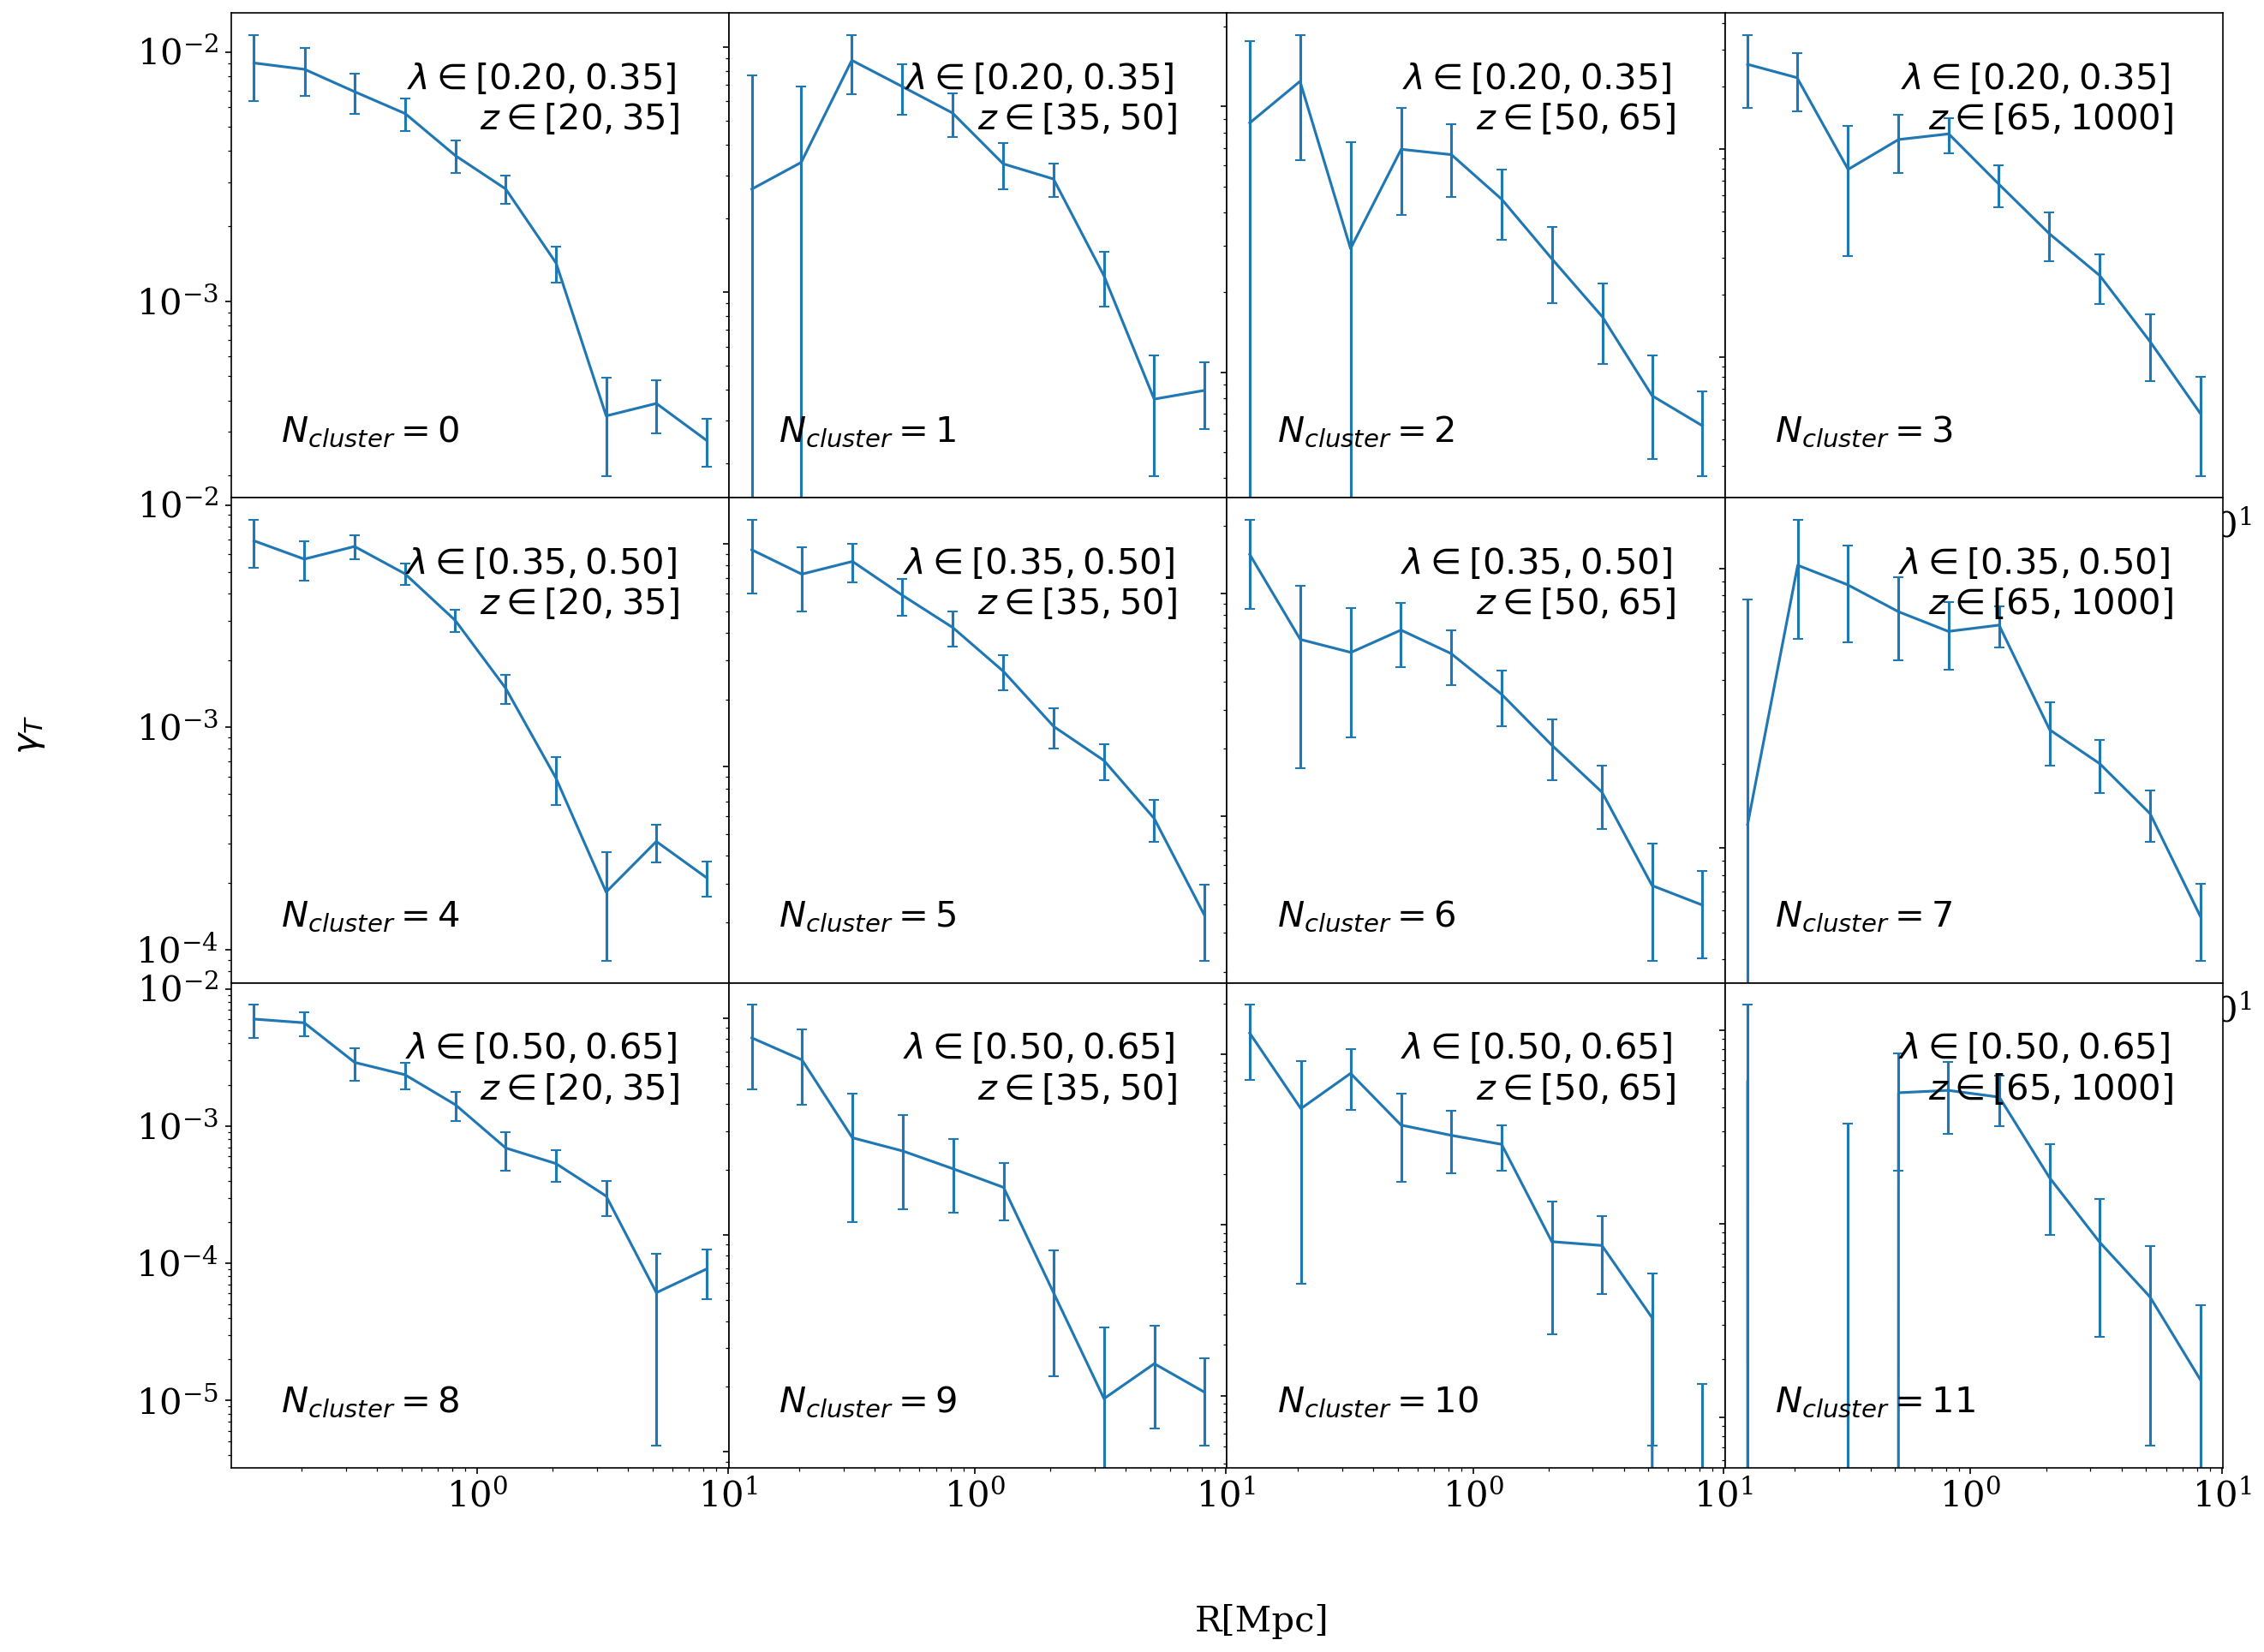

In [25]:
fig, axs = plt.subplots(3, 4,figsize=(20,15),gridspec_kw = {'wspace':0, 'hspace':0},dpi=150)
for i in range(3):
    for j in range(4):
        values=ng_matrix[i][j]
        values_wr=ng_wr_matrix[i][j]
#         axs[i,j].errorbar(np.exp(values[0]),values[1],yerr=np.sqrt(values[2]),label="All sources")
        axs[i,j].errorbar(np.exp(values[0]),values_wr[1],yerr=np.sqrt(values_wr[2]),label="wo/ redMaPPer")
        axs[i,j].set_xscale("log")
        axs[i,j].set_yscale("log")
        axs[i,j].loglog()
        axs[i,j].text(0.1,0.1,r"$N_{{cluster}}={}$".format(nclusters[i,j]),verticalalignment="bottom",
                     horizontalalignment="left",transform=axs[i,j].transAxes)
        axs[i,j].text(0.9,0.9,"$\lambda \in [{:.2f},{:.2f}]$ \n $z \in [{},{}]$".format(z_bins[i],z_bins[i+1],lambda_bins[j],lambda_bins[j+1]),
                      verticalalignment="top",
             horizontalalignment="right",transform=axs[i,j].transAxes)
        
        if j!=0:
            axs[i,j].set_yticklabels([])

# fig.set_xlabel("test")

fig.text(0.5,0.04,"R[Mpc]")
fig.text(0.04,0.5,"$\gamma_T$",rotation="vertical")
fig.subplots_adjust(wspace=None, hspace=None)
#         axs[0,3].legend()
#         axs.xscale("log")
#         axs[i,j].plot(np.exp(values_wr[0]),values_wr[1])

# Jackknife variance

In [12]:
get_xi_meanlogr_varxi_npairs

<function __main__.get_xi_meanlogr_varxi_npairs(cluster, mode1, mode2)>

In [16]:
mask_array=[[None for i in range(4)] for j in range(3)]
mask_array

[[None, None, None, None], [None, None, None, None], [None, None, None, None]]

In [38]:
mask_array[1][2]

In [39]:
def get_binned(_clusters):
    mask_array=[[None for i in range(4)] for j in range(3)]
    
    for i in trange(4): #lambda bins
        for j in trange(3): #z bins
            z_lower,z_upper=z_bins[j],z_bins[j+1]
            lambda_lower,lambda_upper=lambda_bins[i],lambda_bins[i+1]
            
            clusters_z_mask=(_clusters[('All','All','Z_LAMBDA')]>=z_lower)&(_clusters[('All','All','Z_LAMBDA')]<=z_upper)
            clusters_lambda_mask=(_clusters[('All','All','LAMBDA_CHISQ')]>=lambda_lower)&(_clusters[('All','All','LAMBDA_CHISQ')]<=lambda_upper)
            combined_mask=clusters_z_mask&clusters_lambda_mask
            mask_array[j][i]=combined_mask
    return (mask_array)

In [41]:
binned_mask=get_binned(clusters)

In [53]:
def get_jk_single(i,j,_binned_mask):
    ng_dict={}

    import gc
    
    _clusters=clusters[_binned_mask[j][i]]
    
    print(len(_clusters))
    
    for i in trange(len(_clusters)):
        cluster=_clusters.iloc[[i]]
        ng=get_ng_source(cluster,sources,shapes,multi=False)
        ng_dict[cluster.index.to_numpy()[0]]=[cluster[('All','All','Z_LAMBDA')].to_numpy()[0],cluster[('All','All','LAMBDA_CHISQ')].to_numpy()[0],ng.xi,ng.meanlogr,ng.npairs]
        del ng
        gc.collect()
        
    ng_df=pd.DataFrame.from_dict(ng_dict,orient='index')
    ng_df.to_pickle("/global/project/projectdirs/des/zhou/sa/data/gammaT/jk_lensing_{j}_{i}.pkl".format(i,j))
    

In [ ]:
get_jk_single(0,0,binned_mask)

371


In [ ]:
def ng_df_to_list(ng_df):
    for i,row in ng_df.iterrows():
        ng_vals=np.array([row.xi,ng.meanlogr,ng.varxi,ng.npairs]
        ng_list=np.empty([length,4,NBINS])
        ng_list

In [27]:
def get_cov_for_panel(i,j):
    z_lower,z_upper=z_bins[i,i+1]
    lambda_lower,lambda_upper=lambda_bins[j,j+1]
    
    clusters_z_mask=(_clusters[('All','All','Z_LAMBDA')]>=z_lower)&(_clusters[('All','All','Z_LAMBDA')]<=z_upper)
    clusters_lambda_mask=(_clusters[('All','All','LAMBDA_CHISQ')]>=lambda_lower)&(_clusters[('All','All','LAMBDA_CHISQ')]<=lambda_upper)
    combined_mask=clusters_z_mask&clusters_lambda_mask
    
    
    ng_list=    ng_list=np.empty([length,4,NBINS])


In [ ]:
def get_cov(ng_list):
    
    
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    if N!=0:
    
        jk_xi_array=np.empty([N,NBINS])

        def get_xi(drop_1_xi,drop_1_npairs):
            return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))

        for i in range(N):
            drop_1_xi=np.delete(xi_array,i,axis=0)
            drop_1_npairs=np.delete(npairs_array,i,axis=0)
            jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)

            mean=np.mean(jk_xi_array,axis=0)
            
        jk_cov=np.empty([NBINS,NBINS])
        
        for i in range(NBINS):
            for j in range(NBINS):
                jk_cov[i,j]=(1-1/N)*np.sum((jk_xi_array[:,i]-mean[i])*(jk_xi_array[:,j]-mean[j]))
        return(jk_cov)
    else:
        return(0*np.ones(NBINS))